# タイタニックの生存予測  
https://signate.jp/competitions/102/

## ライブラリのインストール

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

## データの読み込み

In [2]:
train = pd.read_csv("train.tsv", sep="\t", index_col=0) # 学習用データ
test = pd.read_csv("test.tsv", sep="\t", index_col=0)   # 評価用データ
sample_submit = pd.read_csv("sample_submit.tsv", sep="\t", index_col=0, header=None) # 応募用サンプルファイル

In [3]:
train.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked
id,,,,,,,,
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
7,0,3,male,2.0,3,1,21.0750,S
9,1,2,female,14.0,1,0,30.0708,C
11,1,1,female,58.0,0,0,26.5500,S


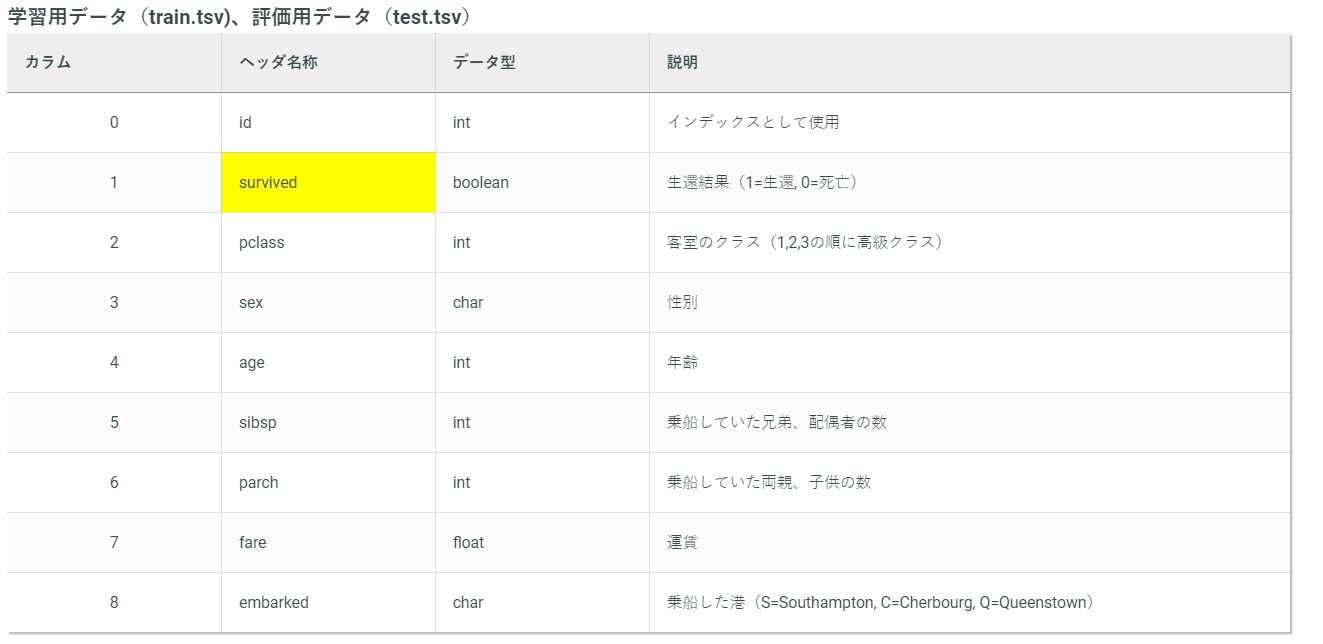

学習用データ（train.tsv)、評価用データ（test.tsv）
カラム	ヘッダ名称	データ型	説明  
0	id	int	インデックスとして使用  
1	survived	boolean	生還結果（1=生還, 0=死亡）  
2	pclass	int	客室のクラス（1,2,3の順に高級クラス）  
3	sex	char	性別  
4	age	int	年齢  
5	sibsp	int	乗船していた兄弟、配偶者の数  
6	parch	int	乗船していた両親、子供の数  
7	fare	float	運賃  
8	embarked	char	乗船した港（S=Southampton, C=Cherbourg, Q=Queenstown）

## データの確認

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 445 entries, 3 to 888
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  445 non-null    int64  
 1   pclass    445 non-null    int64  
 2   sex       445 non-null    object 
 3   age       360 non-null    float64
 4   sibsp     445 non-null    int64  
 5   parch     445 non-null    int64  
 6   fare      445 non-null    float64
 7   embarked  443 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 31.3+ KB


In [5]:
train['survived'].value_counts()

survived
0    266
1    179
Name: count, dtype: int64

(array([28., 23., 91., 83., 64., 39., 16., 12.,  3.,  1.]),
 array([ 0.67 ,  8.603, 16.536, 24.469, 32.402, 40.335, 48.268, 56.201,
        64.134, 72.067, 80.   ]),
 <BarContainer object of 10 artists>)

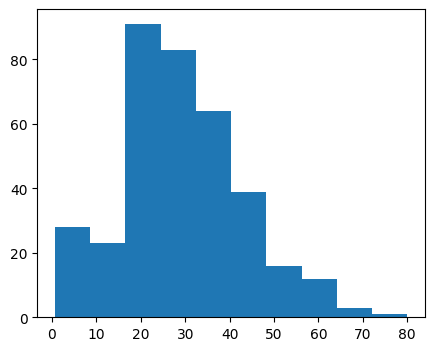

In [6]:
plt.figure(figsize=(5,4))
plt.hist(train["age"])

array([[<Axes: title={'center': 'survived'}>,
        <Axes: title={'center': 'pclass'}>],
       [<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'sibsp'}>],
       [<Axes: title={'center': 'parch'}>,
        <Axes: title={'center': 'fare'}>]], dtype=object)

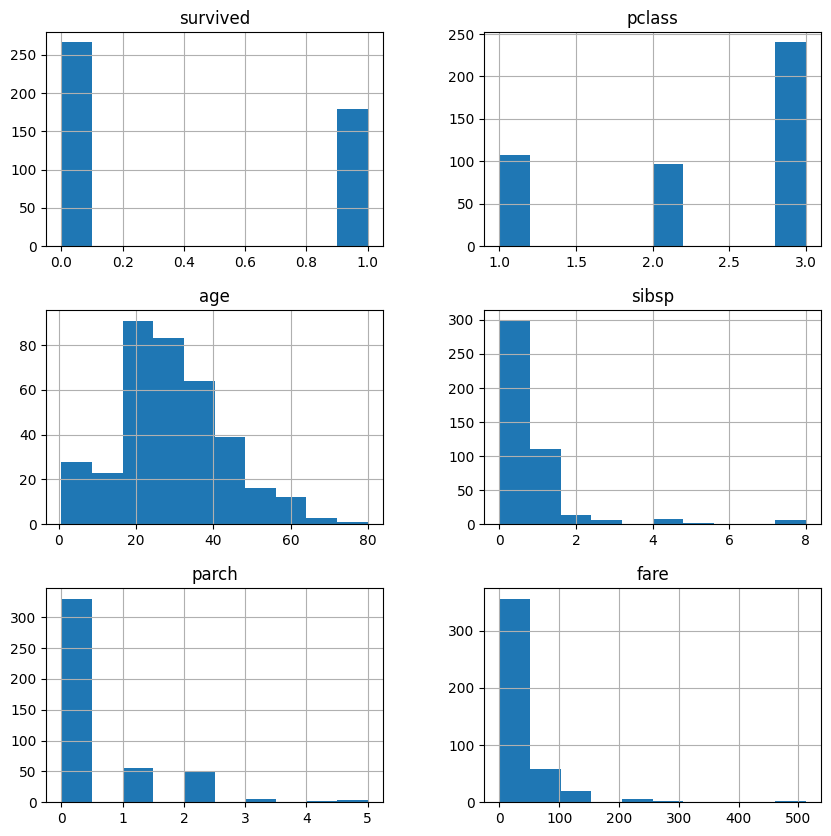

In [7]:
train.hist(figsize=(10,10))

(array([156.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 289.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

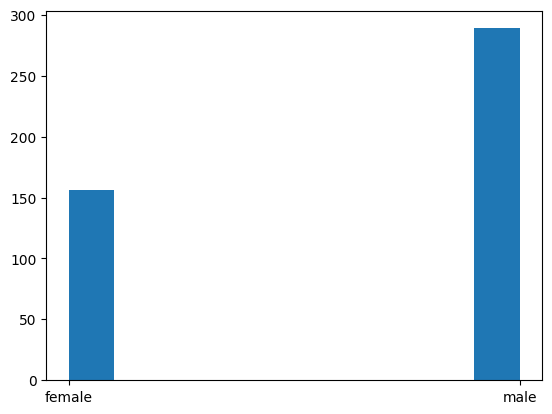

In [8]:
plt.hist(train["sex"])

In [9]:
train[["survived", "sex"]].groupby("sex").mean()

,survived
sex,
female,0.775641
male,0.200692


In [10]:
train[["survived", "pclass"]].groupby("pclass").mean()

,survived
pclass,
1,0.685185
2,0.443299
3,0.258333


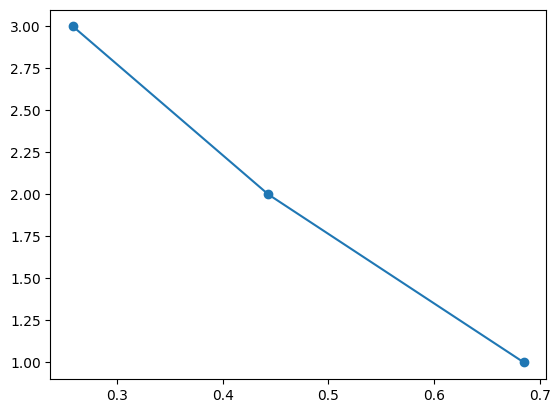

In [11]:
pclass_mean = train[["survived", "pclass"]].groupby("pclass").mean()
plt.plot(pclass_mean["survived"], pclass_mean.index, marker="o")

In [12]:
survived_1 = train[train["survived"]==1]
survived_0 = train[train["survived"]==0]

(array([0.00562825, 0.00562825, 0.02814127, 0.03517659, 0.02321655,
        0.02180948, 0.01266357, 0.00492472, 0.00492472, 0.00281413]),
 array([ 1. ,  7.9, 14.8, 21.7, 28.6, 35.5, 42.4, 49.3, 56.2, 63.1, 70. ]),
 <BarContainer object of 10 artists>)

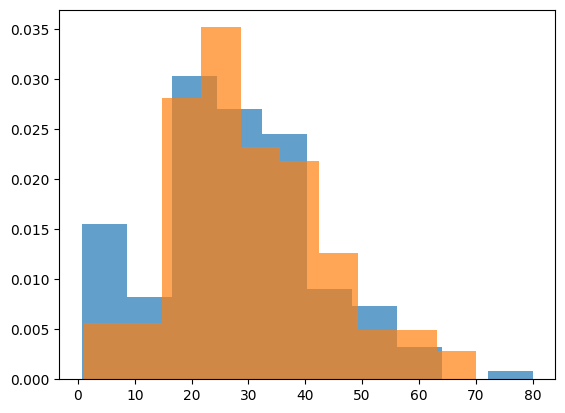

In [13]:
plt.hist(survived_1["age"], density=True, alpha=0.7)
plt.hist(survived_0["age"], density=True, alpha=0.7)

In [14]:
pd.cut(train["age"], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80])

id
3      (30.0, 40.0]
4      (30.0, 40.0]
7       (0.0, 10.0]
9      (10.0, 20.0]
11     (50.0, 60.0]
           ...     
873    (40.0, 50.0]
874    (20.0, 30.0]
879    (50.0, 60.0]
884    (20.0, 30.0]
888             NaN
Name: age, Length: 445, dtype: category
Categories (8, interval[int64, right]): [(0, 10] < (10, 20] < (20, 30] < (30, 40] < (40, 50] < (50, 60] < (60, 70] < (70, 80]]

In [15]:
age_mean = train[["age", "survived"]].groupby(pd.cut(train["age"], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80])).mean()
age_mean

,age,survived
age,,
"(0, 10]",4.065758,0.575758
"(10, 20]",17.325000,0.450000
"(20, 30]",25.393805,0.389381
"(30, 40]",35.060241,0.469880
"(40, 50]",45.011111,0.311111
"(50, 60]",55.558824,0.470588
"(60, 70]",64.125000,0.250000
"(70, 80]",80.000000,1.000000


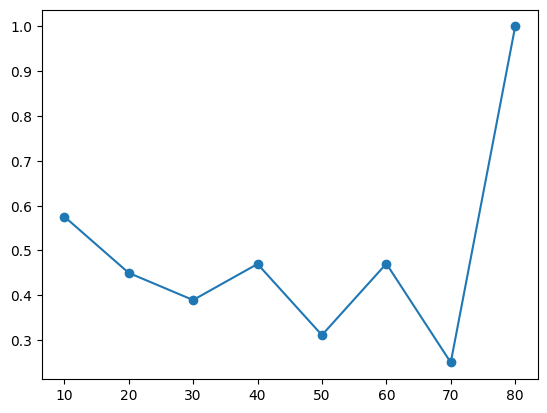

In [16]:
plt.plot([10, 20, 30, 40, 50, 60, 70, 80], age_mean["survived"], marker="o")

In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 446 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    446 non-null    int64  
 1   sex       446 non-null    object 
 2   age       354 non-null    float64
 3   sibsp     446 non-null    int64  
 4   parch     446 non-null    int64  
 5   fare      446 non-null    float64
 6   embarked  446 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 27.9+ KB


array([[<Axes: title={'center': 'pclass'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'sibsp'}>,
        <Axes: title={'center': 'parch'}>],
       [<Axes: title={'center': 'fare'}>, <Axes: >]], dtype=object)

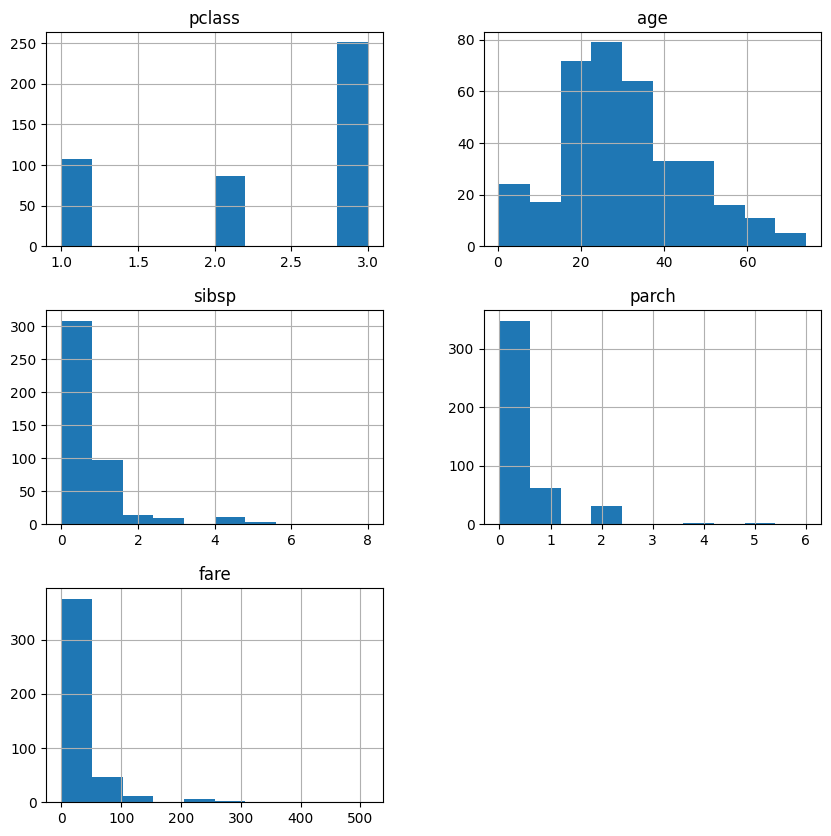

In [18]:
test.hist(figsize=(10,10))

Text(0.5, 1.0, 'test')

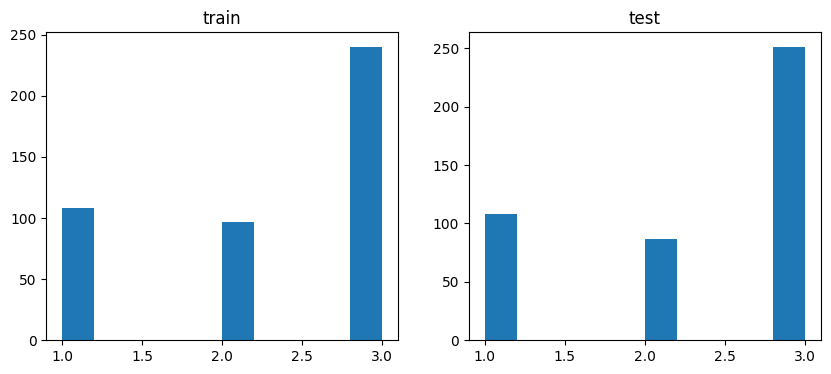

In [19]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(train["pclass"])
plt.title("train")
plt.subplot(1,2,2)
plt.hist(test["pclass"])
plt.title("test")

## データの前処理

In [20]:
le = LabelEncoder()
train["sex"] = le.fit_transform(train["sex"])
le.classes_

array(['female', 'male'], dtype=object)

In [21]:
le = LabelEncoder()
train["embarked"] = le.fit_transform(train["embarked"])
le.classes_

array(['C', 'Q', 'S', nan], dtype=object)

In [22]:
train

,survived,pclass,sex,age,sibsp,parch,fare,embarked
id,,,,,,,,
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2
7,0,3,1,2.0,3,1,21.0750,2
9,1,2,0,14.0,1,0,30.0708,0
11,1,1,0,58.0,0,0,26.5500,2
...,...,...,...,...,...,...,...,...
873,0,3,1,47.0,0,0,9.0000,2
874,1,2,0,28.0,1,0,24.0000,0
879,1,1,0,56.0,0,1,83.1583,0


In [23]:
data = train.drop(["survived", "age"], axis=1)
data

,pclass,sex,sibsp,parch,fare,embarked
id,,,,,,
3,1,0,1,0,53.1000,2
4,3,1,0,0,8.0500,2
7,3,1,3,1,21.0750,2
9,2,0,1,0,30.0708,0
11,1,0,0,0,26.5500,2
...,...,...,...,...,...,...
873,3,1,0,0,9.0000,2
874,2,0,1,0,24.0000,0
879,1,0,0,1,83.1583,0


In [24]:
target = train["survived"]
target

id
3      1
4      0
7      0
9      1
11     1
      ..
873    0
874    1
879    1
884    0
888    0
Name: survived, Length: 445, dtype: int64

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.1, stratify=target)
len(X_valid)

45

In [26]:
X_valid

,pclass,sex,sibsp,parch,fare,embarked
id,,,,,,
508,3,1,0,0,22.5250,2
814,3,1,0,0,8.0500,2
791,2,1,0,0,26.0000,2
394,3,0,0,2,16.7000,2
684,2,1,1,1,39.0000,2
502,3,0,0,0,7.6292,1
405,2,1,1,0,21.0000,2
343,2,1,0,0,13.0000,2
328,3,0,1,1,20.5250,2


## モデルの作成と評価

In [27]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [28]:
y_pred = model.predict(X_valid)
y_pred

array([0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1], dtype=int64)

In [29]:
roc_auc_score(y_valid, y_pred)

0.8148148148148148

## 提出データの作成

In [30]:
test

,pclass,sex,age,sibsp,parch,fare,embarked
id,,,,,,,
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
5,3,male,NaN,0,0,8.4583,Q
6,1,male,54.0,0,0,51.8625,S
...,...,...,...,...,...,...,...
885,3,female,39.0,0,5,29.1250,Q
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S


In [31]:
le = LabelEncoder()
test["sex"] = le.fit_transform(test["sex"])
le.classes_

array(['female', 'male'], dtype=object)

In [32]:
le = LabelEncoder()
test["embarked"] = le.fit_transform(test["embarked"])
le.classes_

array(['C', 'Q', 'S'], dtype=object)

In [33]:
test

,pclass,sex,age,sibsp,parch,fare,embarked
id,,,,,,,
0,3,1,22.0,1,0,7.2500,2
1,1,0,38.0,1,0,71.2833,0
2,3,0,26.0,0,0,7.9250,2
5,3,1,NaN,0,0,8.4583,1
6,1,1,54.0,0,0,51.8625,2
...,...,...,...,...,...,...,...
885,3,0,39.0,0,5,29.1250,1
886,2,1,27.0,0,0,13.0000,2
887,1,0,19.0,0,0,30.0000,2


In [34]:
X_test = test.drop("age", axis=1)
X_test

,pclass,sex,sibsp,parch,fare,embarked
id,,,,,,
0,3,1,1,0,7.2500,2
1,1,0,1,0,71.2833,0
2,3,0,0,0,7.9250,2
5,3,1,0,0,8.4583,1
6,1,1,0,0,51.8625,2
...,...,...,...,...,...,...
885,3,0,0,5,29.1250,1
886,2,1,0,0,13.0000,2
887,1,0,0,0,30.0000,2


In [35]:
y_submit = model.predict(X_test)
y_submit

array([0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,

In [36]:
sample_submit

,1
0,
0,0
1,1
2,0
5,1
6,1
...,...
885,1
886,1
887,1


In [37]:
sample_submit[1] = y_submit
sample_submit

,1
0,
0,0
1,1
2,1
5,0
6,0
...,...
885,1
886,0
887,1


In [38]:
sample_submit.to_csv('submit.tsv', header=None, sep='\t')